# Backbone congelada y descongelada

## Backbone y head

Antes de nada hay que explicar qué son el backbone y el head de una red neuronal convolucional. Como ya vimos, una arquitectura de red convolucional se compone de un montón de capas convolucionales, pooling y funciones no lineales repetidas, y por último una o varias capas de tipo fully connected. Por tanto se suele llamar backbone a la parte donde está todo el conjunto de capas convolucionales, y head a la capa o capas fully connected

![CNN](Imagenes/CNN.jpeg)

En la anterior imagen, el *feature learning*, o extractor de características, corresponde al *backbone* y la parte de *classification* corresponde a la head

Esta separación de la red se hace porque el backbone es el extractor de características (feature extractor), es decir, es capaz de sacar todas las características importantes de la imagen, y luego una head es la que es capaz de realizar por ejemplo la clasififcación analizando esas características y metiéndolas en una pequeña red fully connected.

Por tanto, una misma backbone puede ser usada para distintas tareas solo cambiando la head

## Congelar el backbone

Como hemos dicho, una misma backbone puede servir para distintas tareas solo poniendo distintas heads. Pero qué pasa si no tenemos heads para una nueva tarea, tendremos que crear una nueva y entrenarla.

Sin embargo cuando entrenamos una red, la entrenamos entera, tanto el backbone como la head. Pero entrenar el backbone no tiene sentido, ya que ya sabe extraer las características importantes de las imágenes. Por lo que reentrenarlo, solo puede llevar a sobreentrenamientos, y tardar mucho más (ya que al haber más capas, hay más cálculos) en cada epoch

Puede que tengamos un problema muy parecido a Imagenet, por ejemplo, queremos una red que sepa distinguir entre perros y gatos. Las redes preentrenadas para Imagenet ya saben clasificar perros y gatos, es decir, saben sacar las características de estos en una imagen, por lo que no tiene sentido reentrenarla

Para solucionar esto, lo que se hace es congelar el backbone. Así, en el ejemplo de gatos y perros, vamos a tener una backbone que ya sabe sacar las características, pero que al entrenar la red no se va a modificar. Además le vamos a añadir una nueva head, que solo clasifica entre perros y gatos, que esta sí que va a hacer falta entrenarla

## Como congelar en Pytorch

En Pytorch, cada parámetro de la red tiene un atributo llamado `data` y otro llamado `requires_grad`

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    if i < 1:
        print(type(param.data), param.requires_grad)

<class 'torch.Tensor'> True


Por lo que para congelar el backbone podemos congelar toda la red, menos la última capa fully connected

In [5]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
model.fc.requires_grad = True

Al hacer esto, Pytorch no calculará los gradientes en el backbone, solo en la capa fully connected, por lo que solo actualizará los pesos de la capa fully connected

## Ejemplo de entrenamiento con backbone congelada

Vamos a ver un ejemplo de entrenamiento de una red con el backbone congelado, para reconocer entre gatos y perros, para ello usaremos el dataset [cats vs dogs](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset). Lo descargo desde kaggle y lo guardo en `data/cats_vs_dogs`

### EDA

Vemos el archivo que se ha descargado

In [10]:
!ls data

cats_vs_dogs.zip  cifar-10-batches-py  cifar-10-python.tar.gz  intel  MNIST


Lo descomprimimos

In [34]:
!unzip -q data/cats_vs_dogs.zip -d data/cats_vs_dogs

Vemos qué tenemos ahora

In [11]:
!ls data/cats_vs_dogs

'MSR-LA - 3467.docx'   PetImages  'readme[1].txt'


Aprovechamos y borramos el *.zip* para ahorrar espacio

In [12]:
!rm data/cats_vs_dogs.zip

Vemos qué hay dentro de `PetImages`

In [13]:
!ls data/cats_vs_dogs/PetImages

Cat  Dog


Hay una carpeta con fotos de gatos y otra con fotos de perros

In [14]:
!ls data/cats_vs_dogs/PetImages/Cat | head -5

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
ls: error de escritura: Tubería rota


In [16]:
!ls data/cats_vs_dogs/PetImages/Dog | head -5

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
ls: error de escritura: Tubería rota


### Dataframe

A la hora de hacer el cuaderno vi que algunas imágenes estaban mal, así que vamos a buscarlas y eliminarlas

Buscamos primero en la carpeta de gatos

In [37]:
import os
import pandas as pd
import cv2

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


Vemos los posiles valores de la columna type

In [50]:
df_cats.type.unique()

array([<class 'numpy.ndarray'>], dtype=object)

Como se puede ver hay arrays de numpy y `None`s. Por lo que vamos a borrar los últimos

In [41]:
df_cats = df_cats[df_cats.type != type(None)]
df_cats.type.unique()

array([<class 'numpy.ndarray'>], dtype=object)

Hacemos lo mismo con los perros

In [44]:
df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs.type.unique()

Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


array([<class 'numpy.ndarray'>, <class 'NoneType'>], dtype=object)

In [45]:
df_dogs = df_dogs[df_dogs.type != type(None)]
df_dogs.type.unique()

array([<class 'numpy.ndarray'>], dtype=object)

Creamos un solo dataframe con la unión de los dos

In [46]:
df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])
df.head()

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

,path,label,type,height,width
0,data/cats_vs_dogs/PetImages/Cat/8627.jpg,0,<class 'numpy.ndarray'>,500,490
1,data/cats_vs_dogs/PetImages/Cat/10464.jpg,0,<class 'numpy.ndarray'>,453,500
2,data/cats_vs_dogs/PetImages/Cat/11263.jpg,0,<class 'numpy.ndarray'>,92,183
3,data/cats_vs_dogs/PetImages/Dog/2757.jpg,1,<class 'numpy.ndarray'>,392,500
4,data/cats_vs_dogs/PetImages/Dog/10997.jpg,1,<class 'numpy.ndarray'>,165,234


Vemos los posibles tamaños de las imágenes

In [48]:
df.height.max(), df.height.min(), df.height.mean(), df.height.median()

(500, 4, 361.20183596568586, 375.0)

In [49]:
df.width.max(), df.width.min(), df.width.mean(), df.width.median()

(500, 4, 404.8657500200433, 448.0)

Como vemos la media de tamaños es 375x448, así que en el dataset redimensionaremos las imágenes a ese tamaño

In [52]:
median_shape = (int(df.height.median()), int(df.width.median()))
median_shape

(375, 448)

In [32]:
# get position of images with height = <class 'NoneType'>
df_cats[df_cats['height'] == type(None)].index

Int64Index([  178,  1414,  1525,  1671,  2199,  3146,  4175,  4258,  4435,
             5165,  6534,  6740,  8032,  8483,  8749,  8879,  9004,  9409,
             9935, 10225, 10569, 10597, 10971, 11452, 11811],
           dtype='int64')

In [36]:
df_cats.iloc[1525]['path']

'data/cats_vs_dogs/PetImages/Cat/5553.jpg'

Creamos un diccionario con las clases

In [2]:
classes = {'cat': 0, 'dog': 1}

### Dataset

Creamos el dataset

In [53]:
import torch
import torchvision
import cv2

class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        if img.shape[0] != median_shape[0] or img.shape[1] != median_shape[1]:
            img = cv2.resize(img, median_shape) # Resize image
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img = img / 255.0  # Normalize image
        img = self.norm(img) # Standardize image
        label = self.df.loc[idx, 'label']
        return img, label

In [54]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split),
    'val': DatasetCatsDogs(val_split),
}

print(f"Había {len(df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 24946 imágenes en el dataset, lo hemos dividido en 19956 imágenes de entrenamiento y 4990 imágenes de validación


Vemos una muestra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


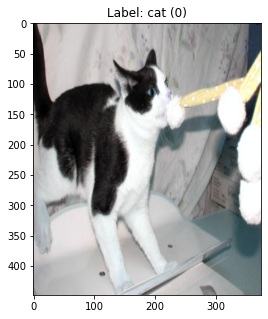

(448, 375, 3)


In [57]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

key = [k for k, v in classes.items() if v == sample_label][0]
fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Label: {key} ({sample_label})")
plt.show()
print(img.shape)

### Dataloaders

In [58]:
BS_train = 32
BS_test = 32

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

In [60]:
batch_img, batch_label = next(iter(dataloader['train']))
print(batch_img.shape)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


torch.Size([32, 3, 448, 375])


In [61]:
batch_img, batch_label = next(iter(dataloader['val']))
print(batch_img.shape)

torch.Size([32, 3, 448, 375])


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


### Model

In [62]:
num_clases = len(classes)
num_clases

2

In [85]:
from torchvision.models import resnet50, ResNet50_Weights

model_freeze = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
model_freeze.fc = torch.nn.Linear(model_freeze.fc.in_features, num_clases)

model_freeze.fc.out_features

AttributeError: 'Linear' object has no attribute 'requires_grad'

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_freeze.to(device)
print("Using {} device".format(device))

Using cuda device


### Entrenamiento

In [74]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_freeze.parameters(), lr=LR, weight_decay=1e-5)

In [75]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches


def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            # print(X.shape, preds.shape, preds.argmax(1), y)
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

In [76]:
epochs = 12
losses_train_freeze = []
losses_val_freeze = []
accuracies_val_freeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model_freeze, loss_fn, optimizer, device)
    losses_train_freeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model_freeze, loss_fn, device)
    losses_val_freeze.append(mean_loss)
    accuracies_val_freeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.186957  [ 9952/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.018925  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 86.5%, Avg loss: 0.312285 

Epoch 2
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.055094  [ 9952/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.052845  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.4%, Avg loss: 0.156036 

Epoch 3
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.101116  [ 9952/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.062430  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.8%, Avg loss: 0.094366 

Epoch 4
-------------------------------


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.051609  [ 9952/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.072074  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 89.3%, Avg loss: 0.291215 

Epoch 5
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.149448  [ 9952/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.015809  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.6%, Avg loss: 0.087268 

Epoch 6
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.054629  [ 9952/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.032374  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.3%, Avg loss: 0.108782 

Epoch 7
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.001900  [ 9952/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.010978  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 92.7%, Avg loss: 0.156069 

Epoch 8
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.135590  [ 9952/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.012017  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 97.4%, Avg loss: 0.071514 

Epoch 9
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.038801  [ 9952/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.098860  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.4%, Avg loss: 0.099268 

Epoch 10
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.052429  [ 9952/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.153457  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.2%, Avg loss: 0.130142 

Epoch 11
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.081569  [ 9952/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.209045  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.9%, Avg loss: 0.103755 

Epoch 12
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.135396  [ 9952/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.026058  [12460/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 97.9%, Avg loss: 0.061437 

Done!


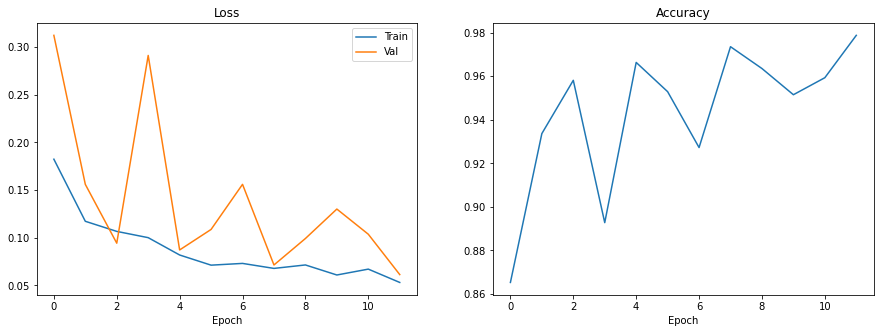

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train_freeze, label='Train')
ax[0].plot(losses_val_freeze, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val_freeze)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

Vamos a ver cómo se comporta con una imagen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


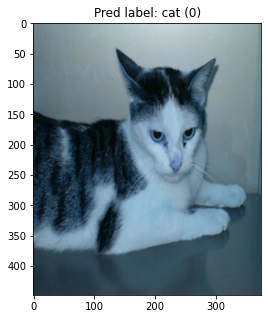

In [81]:
idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

pred = model_freeze(sample_img.unsqueeze(0).to(device))
pred = pred.argmax(1).item()
key = list(classes.keys())[list(classes.values()).index(pred)]

fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Pred label: {key} ({pred})")
plt.show()

## Ejemplo de entrenamiento con backbone descongelada

Para entrenar con una red descongelada nos vale el mismo dataset y dataloader, por lo que comenzamos a partir de crear el modelo

### Model

In [86]:
from torchvision.models import resnet50, ResNet50_Weights

model_unfreeze = resnet50(weights=ResNet50_Weights.DEFAULT)
model_unfreeze.fc = torch.nn.Linear(model_unfreeze.fc.in_features, num_clases)

model_unfreeze.fc.out_features

2

In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_unfreeze.to(device)
print("Using {} device".format(device))

Using cuda device


### Entrenamiento

In [88]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_unfreeze.parameters(), lr=LR, weight_decay=1e-5)

In [89]:
epochs = 12
losses_train_unfreeze = []
losses_val_unfreeze = []
accuracies_val_unfreeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model_unfreeze, loss_fn, optimizer, device)
    losses_train_unfreeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model_unfreeze, loss_fn, device)
    losses_val_unfreeze.append(mean_loss)
    accuracies_val_unfreeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


KeyboardInterrupt: 

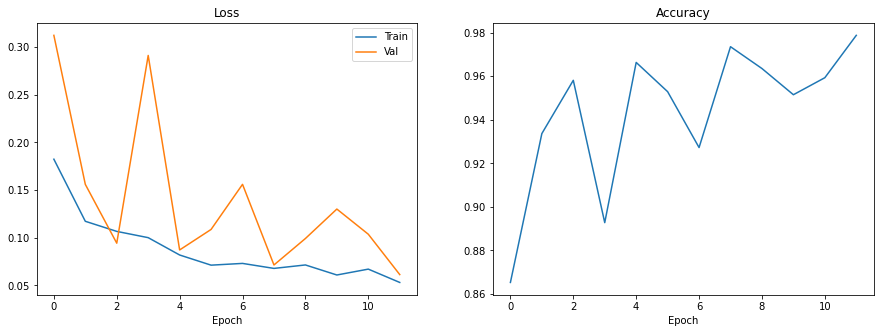

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train_unfreeze, label='Train')
ax[0].plot(losses_val_unfreeze, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val_unfreeze)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

Vamos a ver cómo se comporta con una imagen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


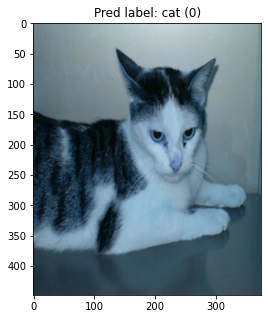

In [ ]:
idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

pred = model_unfreeze(sample_img.unsqueeze(0).to(device))
pred = pred.argmax(1).item()
key = list(classes.keys())[list(classes.values()).index(pred)]

fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Pred label: {key} ({pred})")
plt.show()

## Entrenamiento en 2 pasos (cambiar nombre)